<class 'pandas.core.frame.DataFrame'>
Index: 34187 entries, 31 to 848158
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Фамилия               34187 non-null  object        
 1   Имя                   34187 non-null  object        
 2   Отчетство             33651 non-null  object        
 3   Пол                   34187 non-null  object        
 4   Табельный номер       34187 non-null  object        
 5   id сотрудника         34187 non-null  int64         
 6   АД систолическое      33972 non-null  float64       
 7   АД диастолическое     33972 non-null  float64       
 8   ЧСС                   33972 non-null  float64       
 9   Дата и время осмотра  34187 non-null  datetime64[ns]
 10  id осмотра            34187 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 3.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entri

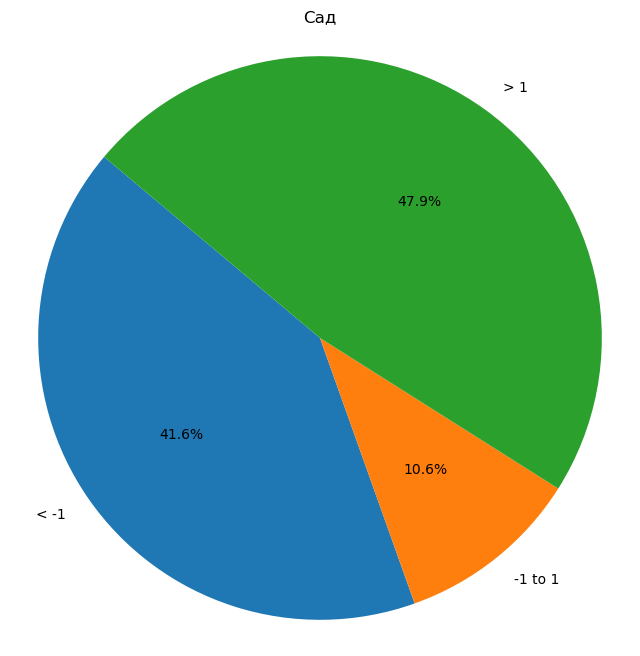

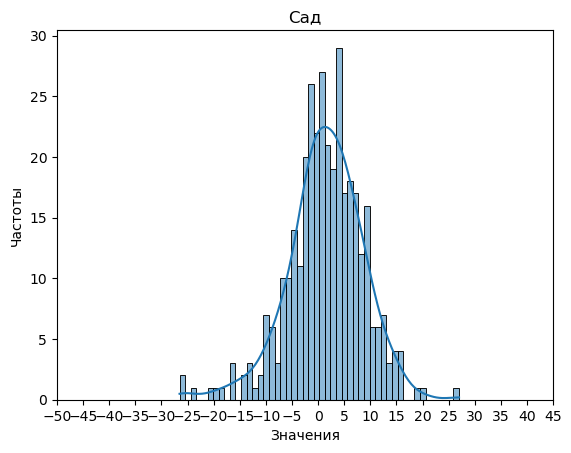

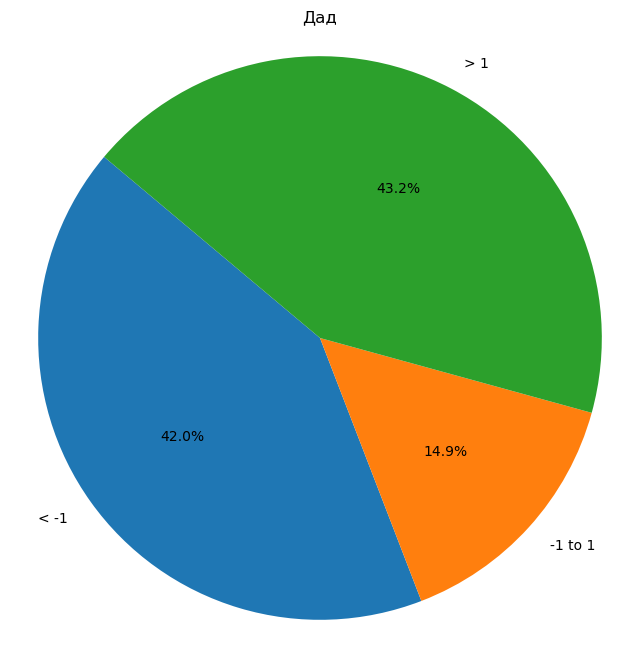

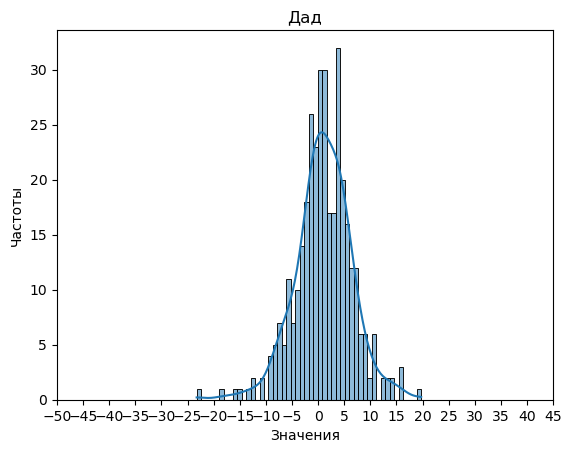

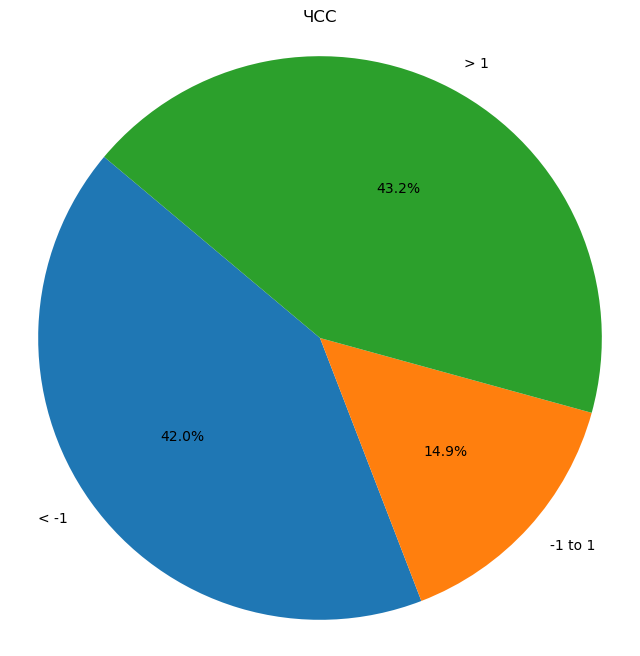

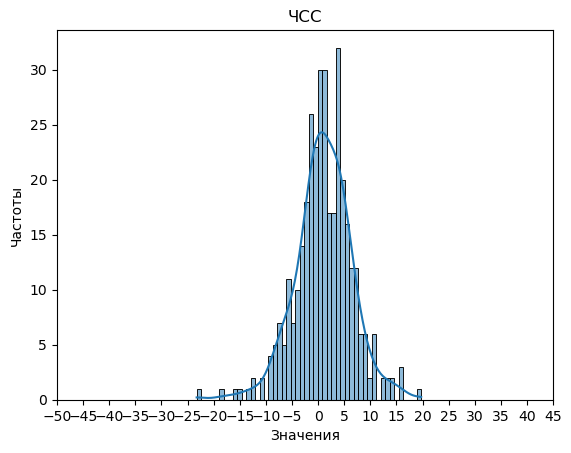

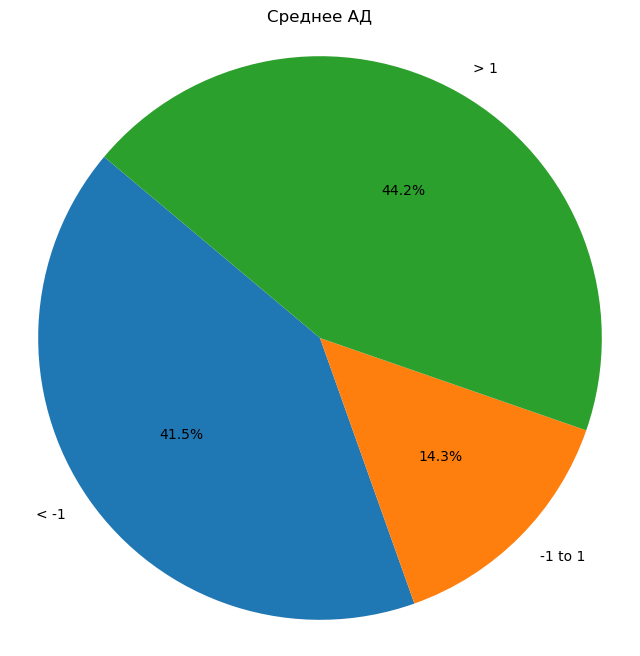

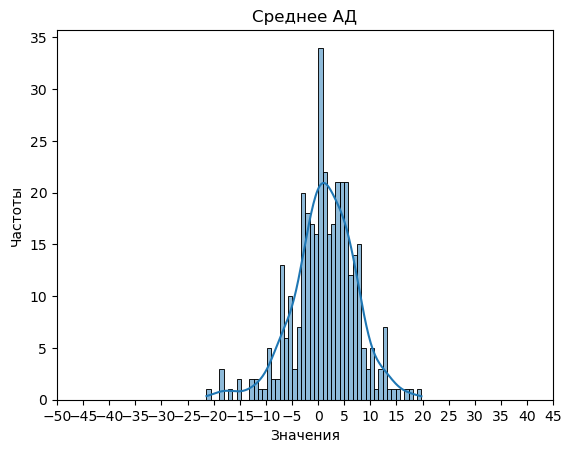

    Табельный номер        Cад        Дад        ЧСС  Среднее АД
0       0000-011512  -3.413793  -4.309113  -4.309113   -3.861453
1       0000-011893   8.946429   4.967381   4.967381    6.956905
2       0000-012340  -0.631604  -0.196353  -0.196353   -0.413978
3       0000-012926   6.302439   6.724042   6.724042    6.513240
4       0000-012990   0.038934   1.008197   1.008197    0.523566
..              ...        ...        ...        ...         ...
350             326   0.533333   0.100000   0.100000    0.316667
351               4  -3.469318  -1.859091  -1.859091   -2.664205
352             455   0.647614   0.179245   0.179245    0.413430
353             534  12.358238  12.757982  12.757982   12.558110
354              98  -6.142857  -4.917460  -4.917460   -5.530159

[355 rows x 5 columns]


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from reportlab.lib import pagesizes
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
from io import BytesIO
import seaborn as sns
#Загружаем файл с показателями водителей за определенный период, которые предварительно выгрузили из БД


inspections = pd.read_csv('C:/Users/g.kuzmin/Desktop/Графики МГТ/МТА/Предрейсовые/МТА предрейсовые август-январь.csv', 
                          sep = ",")
inspections_copy = inspections.copy(deep = True)
inspections_copy
#импортнуть данные с временными метками
xz = pd.read_csv('C:/Users/g.kuzmin/Desktop/Графики МГТ/МТА/МТА август-январь (изменения границ).csv', sep = ',')
xz_copy = xz.copy(deep = True)
xz_copy
# оставляем в осмотрах только те строки, которые есть в изменениях границ
inspections_copy = inspections_copy[inspections_copy['Табельный номер'].isin(xz_copy['Табельный номер'])]
inspections_copy

#Хотим убрать значки часового поясса из столбца "Дата и время осмотра" файла с осмотрами

# Импортируем необходимый модуль для работы с регулярными выражениями
import re



# Функция для удаления всех символов с конца до точки включительно
def remove_characters_from_end(text):
    # Используем регулярное выражение, чтобы найти точку и всё после неё
    result = re.sub(r'\..*$', '', text)
    return result

# Применяем функцию к каждому элементу списка
inspections_copy['Дата и время осмотра'] = [remove_characters_from_end(item) for item in inspections_copy['Дата и время осмотра']]
inspections_copy

#Переводим дату и время осмотра в файле с осмотрами в тип данных дат из float
inspections_copy['Дата и время осмотра'] = pd.to_datetime(inspections_copy['Дата и время осмотра'])
inspections_copy
inspections_copy.info()

#Тут тоже переводим временные метки в тип данных даты и времени из float
xz_copy['Время последнего изменения гранни'] = pd.to_datetime(xz_copy['Время последнего изменения гранни'])
xz_copy
xz_copy.info()


#Рисуем графики

#Группируем данные во фрейме с осмотрами по Табельным номерам
grouped = inspections_copy.sort_values(['Табельный номер','Дата и время осмотра']).groupby('Табельный номер')
# Создайте данные и постройте графики, как в предыдущем ответе

# Создайте PDF-файл
pdf_filename = 'МТА послерейсовые.pdf'
doc = SimpleDocTemplate(pdf_filename, pagesize=letter)
styles = getSampleStyleSheet()
elements = []

for name, group in grouped:
    plt.figure(figsize=(10, 5))
    for column in ['АД систолическое', 'АД диастолическое', 'ЧСС']:
        plt.plot(range(1, len(group) + 1), group[column], label=column)
    
    plt.xlabel('Порядковый номер даты')
    plt.ylabel('Значение')
    plt.title(f'Зависимость параметров от времени (Табельный номер {name})')
    step = 20
    plt.xticks(range(1, len(group) + 1, step))
    plt.legend()
    plt.grid()

    a = group['Дата и время осмотра'].tolist()
    b = xz_copy['Время последнего изменения гранни'][xz_copy['Табельный номер'] == name].tolist()
    combined_list = a + b 
    combined_list.sort()
    index = combined_list.index(b[0])
    plt.axvline(x=index, color='red', linestyle='--', label='Последнее изменение')
    
    # Сохраните изображение в буфер
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)

# Добавьте изображение в PDF
    elements.append(Paragraph(f'Табельный номер: {name}', styles['Title']))
    elements.append(Image(buffer, width=400, height=200))

# Очистите текущий график для следующего цикла
    plt.close()

# Создайте PDF файл
doc.build(elements)


# графики для excel
data_sys = inspections_copy.loc[:, ['Табельный номер', 'Дата и время осмотра','АД систолическое']]
data_sys = data_sys.dropna()
grouped_1 = data_sys.groupby('Табельный номер')

data_dis = inspections_copy.loc[:, ['Табельный номер', 'Дата и время осмотра','АД диастолическое']]
data_dis = data_dis.dropna()
grouped_2 = data_dis.groupby('Табельный номер')

chss = inspections_copy.loc[:, ['Табельный номер', 'Дата и время осмотра','АД диастолическое']]
chss = chss.dropna()
grouped_3 = chss.groupby('Табельный номер')



def graphics_excel(grupka,var,graph_title = ''):
    dataa = [] 
    data2 = pd.DataFrame(columns=['Табельный номер', graph_title])
    for name, group in grupka:
        a = group['Дата и время осмотра'].tolist()
        b = xz_copy['Время последнего изменения гранни'][xz_copy['Табельный номер'] == name].tolist()
        combined_list = a + b 
        combined_list.sort()
        index = combined_list.index(b[0])
        less = combined_list[:index]
        more = combined_list[index:]

        filtered_df_less = group[group['Дата и время осмотра'].isin(less)]
        filtered_df_more = group[group['Дата и время осмотра'].isin(more)]

        matozh1 = np.mean(filtered_df_less.iloc[:, 2])
        matozh2 = np.mean(filtered_df_more.iloc[:, 2])
        konech = matozh2 - matozh1
        
        data2.loc[len(data2.index)] = [name, konech]
        dataa.append(konech)
        
    var = data2
    
    
    dataa = list(filter(lambda x: not np.isnan(x), dataa))
   # Разделяем данные на три категории
    less_than_1 = sum(x < 1 for x in dataa)
    equal_to_1 = sum(-1 <= x <= 1 for x in dataa)
    greater_than_1 = sum(x > 1 for x in dataa)

    # Создаем подписи и значения для круговой диаграммы
    labels = ['< -1', '-1 to 1', '> 1']
    sizes = [less_than_1, equal_to_1, greater_than_1]

    # Создаем круговую диаграмму
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(graph_title)
    plt.axis('equal')  # Делаем круг круглым
    plt.show()
    
    sns.histplot(dataa, kde=True, bins = 50)  # Указываем шаги по горизонтали и вертикали
    plt.xlabel('Значения')  # Подпись оси X
    plt.ylabel('Частоты')   # Подпись оси Y
    plt.title(graph_title)  # Заголовок графика
    plt.xticks(range(-50, 50, 5))
    plt.show()
    
    return var
    
data1 = pd.DataFrame()
data22 = pd.DataFrame()
data3 = pd.DataFrame()
data1 = graphics_excel(grouped_1,data1,'Cад')
data22 = graphics_excel(grouped_2,data22,'Дад')
data3 = graphics_excel(grouped_3,data3,'ЧСС')



data = pd.DataFrame(columns=['Табельный номер', 'Среднее АД'])
data4 = pd.DataFrame(columns=['Табельный номер', 'Среднее АД'])
#Группируем данные во фрейме с осмотрами по Табельным номерам
grouped = inspections_copy.sort_values(['Табельный номер','Дата и время осмотра']).groupby('Табельный номер')


#Рассчеты для другой части графика (для курговый диаграмм и для гистограмм в эксельке)
for name, group in grouped:
    a = group['Дата и время осмотра'].tolist()
    b = xz_copy['Время последнего изменения гранни'][xz_copy['Табельный номер'] == name].tolist()
    combined_list = a + b 
    combined_list.sort()
    index = combined_list.index(b[0])
    less = combined_list[:index]
    more = combined_list[index:]
    
    filtered_df_less = group[group['Дата и время осмотра'].isin(less)]
    filtered_df_more = group[group['Дата и время осмотра'].isin(more)]
    

    srednee_less = np.mean((filtered_df_less['АД систолическое'] + filtered_df_less['АД диастолическое']) / 2)
    srednee_more = np.mean((filtered_df_more['АД систолическое'] + filtered_df_more['АД диастолическое']) / 2)
    konech_sred = srednee_more - srednee_less

    data.loc[len(data.index)] = [name, konech_sred]
    data4.loc[len(data.index)] = [name, konech_sred]
    
data['Среднее АД'] = pd.to_numeric(data['Среднее АД'], errors='coerce')
data = data.dropna()


data = data['Среднее АД'].tolist()
less_than_1 = sum(x < 1 for x in data)
equal_to_1 = sum(-1 <= x <= 1 for x in data)
greater_than_1 = sum(x > 1 for x in data)

# Создаем подписи и значения для круговой диаграммы
labels = ['< -1', '-1 to 1', '> 1']
sizes = [less_than_1, equal_to_1, greater_than_1]

# Создаем круговую диаграмму
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Среднее АД')
plt.axis('equal') # Делаем круг круглым
plt.show()

sns.histplot(data, kde=True, bins = 50) # Указываем шаги по горизонтали и вертикали
plt.xlabel('Значения') # Подпись оси X
plt.ylabel('Частоты') # Подпись оси Y
plt.title('Среднее АД') # Заголовок графика
plt.xticks(range(-50, 50, 5))
plt.show()




data4 = data4.dropna()
data22 = data22.dropna()
data3 = data3.dropna()
data1 = data1.dropna()
# Объединяем DataFrame по столбцу 'personal number'
result = pd.merge(data1, data22, on='Табельный номер', how='outer')
result = pd.merge(result, data3, on='Табельный номер', how='outer')
result = pd.merge(result, data4, on='Табельный номер', how='outer')

print(result)


result.to_excel("левая_часть_эксель.xlsx", index=False)

    





In [12]:
data1

,Табельный номер,Cад
0,0000-011512,-3.413793
1,0000-011893,8.946429
2,0000-012340,-0.631604
3,0000-012926,6.302439
4,0000-012990,0.038934
...,...,...
360,326,0.533333
361,4,-3.469318
362,455,0.647614
363,534,12.358238


In [13]:
data22

,Табельный номер,Дад
0,0000-011512,-4.309113
1,0000-011893,4.967381
2,0000-012340,-0.196353
3,0000-012926,6.724042
4,0000-012990,1.008197
...,...,...
360,326,0.100000
361,4,-1.859091
362,455,0.179245
363,534,12.757982


In [14]:
data3

,Табельный номер,ЧСС
0,0000-011512,-4.309113
1,0000-011893,4.967381
2,0000-012340,-0.196353
3,0000-012926,6.724042
4,0000-012990,1.008197
...,...,...
360,326,0.100000
361,4,-1.859091
362,455,0.179245
363,534,12.757982


In [15]:
data4

,Табельный номер,Среднее АД
1,0000-011512,-3.861453
2,0000-011893,6.956905
3,0000-012340,-0.413978
4,0000-012926,6.513240
5,0000-012990,0.523566
...,...,...
361,326,0.316667
362,4,-2.664205
363,455,0.413430
364,534,12.558110
